In [123]:
import numpy as np 
import pandas as pd
import scipy
from scipy import signal
from scipy.io import loadmat
from scipy.interpolate import interp1d

In [3]:
from matplotlib import pyplot as plt

In [4]:
from sklearn.cross_decomposition import PLSRegression

In [5]:
import time

In [6]:
df = pd.read_csv('ECoG.csv')

In [7]:
motion = pd.read_csv('Motion.csv')

## Данные Мотренко

In [252]:
X_mat = loadmat('ECoG_X_train.mat')
Y_mat = loadmat('ECoG_Y_train.mat')

In [267]:
X1 = X_mat["X_train"].reshape((X_mat["X_train"].shape[0],X_mat["X_train"].shape[1]*X_mat["X_train"].shape[2]))
Y1 = Y_mat["Y_train"]

In [271]:
X1.shape

(12801, 864)

In [275]:
model1 = PLSRegression(n_components=100)
model1.fit(X1,Y1)

PLSRegression(copy=True, max_iter=500, n_components=100, scale=True,
       tol=1e-06)

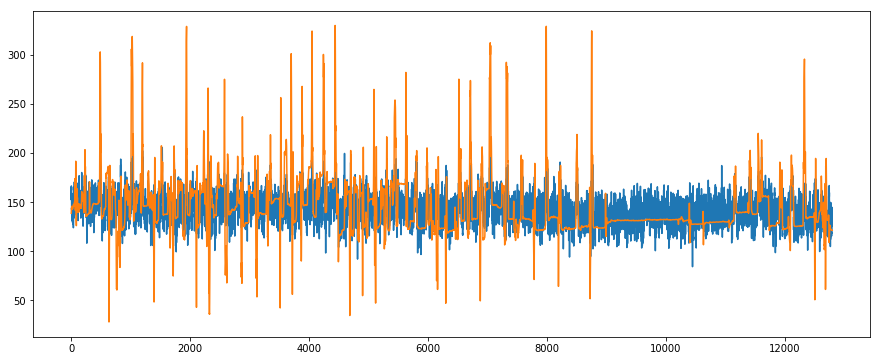

In [279]:
Y_pred1 = model1.predict(X1)
plt.figure(figsize=(15,6))
plt.plot(range(Y_pred1.shape[0]), Y_pred1[:,0])
plt.plot(range(Y_pred1.shape[0]), Y1[:,0])


In [280]:
class ECoG(object):
    def __init__(self,signal_data,motion_data):
        start = max(signal_data[0,0],motion_data[0,0])
        end = min(signal_data[-1,0],motion_data[-1,0])
        signal_data = signal_data[:,:][(signal_data[:,0]>=start)]
        signal_data = signal_data[:,:][(signal_data[:,0]<=end)]
        motion_data = motion_data[:,:][motion_data[:,0]>= start]
        motion_data = motion_data[:,:][motion_data[:,0]<= end]
        M = []
        for i in range(1,motion_data.shape[1]):
            interpol = interp1d(motion_data[:,0],motion_data[:,i],kind="cubic")
            x = interpol(signal_data[:,0])
            M.append(x)
        self.signal = signal_data[::10,1:]
        self.motion = np.array(M).T[::10,:]
        self.time = signal_data[::10,0]
    def plot_signal(self,start,end,electrodes = 'all'):
        if electrodes == 'all':
            for el in range(self.signal.shape[1]):
                plt.figure(figsize=(14,5))
                plt.plot(self.time[start:end],self.signal[start:end,el])
                plt.title("Electrode "+str(el))
                plt.xlabel("time")
                plt.ylabel("voltage")
                plt.show()
            return
        for el in electrodes:
            plt.figure(figsize=(14,5))
            plt.plot(self.time[start:end],self.signal[start:end,el])
            plt.title("Electrode"+str(el))
            plt.xlabel("time")
            plt.ylabel("voltage")
            plt.show()
        return
    def spectrum(self,start,end,freq,electrodes = 'all'):
        if electrodes == 'all':
            X = np.empty((self.signal.shape[1],end-start-110,len(freq),11))
            for el in range(self.signal.shape[1]):
                S = self.signal[start:end,el]
                X[el,:,:,:] = np.array([signal.cwt(S[i-110:i:10],wavelet= signal.morlet ,widths= freq) for i in range(start + 110,end-start)])
            return X
        for el in electrodes:
            S = self.signal[start:end,el]
            M = np.array([signal.cwt(S[i-110:i:10],wavelet= signal.morlet ,widths= freq) for i in range(end - start + 1110)])
            return M

    def plot_spectrum(self,start ,end,freq,electrodes = 'all'):
        if electrodes == 'all':
            for el in range(self.signal.shape[1]):
                S = self.signal[start:end,el]
                X = signal.cwt(data=S,wavelet= signal.morlet ,widths= freq)
                plt.figure(figsize=(15,14))
                plt.imshow(X,cmap='hot')
                plt.title("Electrode "+ str(el))
                plt.show()
            return
        for el in electrodes:
            S = self.signal[start:end,el]
            X = signal.cwt(data=S,wavelet= signal.morlet ,widths= freq)
            plt.figure(figsize=(15,14))
            plt.imshow(X,cmap='hot')
            plt.title("Electrode "+ str(el))
            plt.show()
        return

In [231]:
sig1 = ECoG(df.values[:,:],motion.values[:,:])

In [234]:
%%time
Spec = sig1.spectrum(0,100000,range(10,110,10)) #извлечение признаков

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


Wall time: 30min 50s


In [236]:
X = Spec[0].reshape((Spec.shape[1],Spec.shape[2]*Spec.shape[3])) #вытягивание в вектор
for i in range(1,Spec.shape[0]):
    X = np.hstack((X,Spec[i].reshape((Spec.shape[1],Spec.shape[2]*Spec.shape[3]))))

(32, 99890, 10, 11)

In [184]:
Y = sig1.motion[110:100000,15:18]

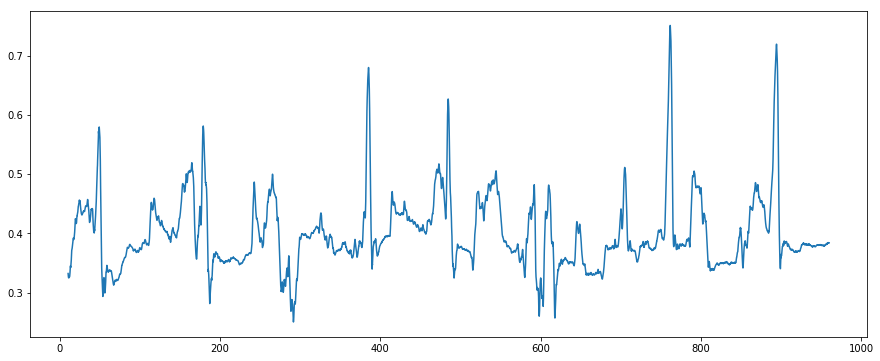

In [243]:
plt.figure(figsize=(15,6))
plt.plot(sig1.time[1100:100000,],Y[:,0]) 

In [185]:
X = (X - X.mean())/X.std()
Y = (Y - Y.mean())/Y.std()

In [247]:
X_train = X[:75000,:]
Y_train = Y[:75000,:]

In [212]:
X1 = X[::10,:]
Y1 = Y[::10,:]

In [248]:
%%time
model = PLSRegression(n_components= 50,max_iter = 700)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_train)

Wall time: 8min 6s


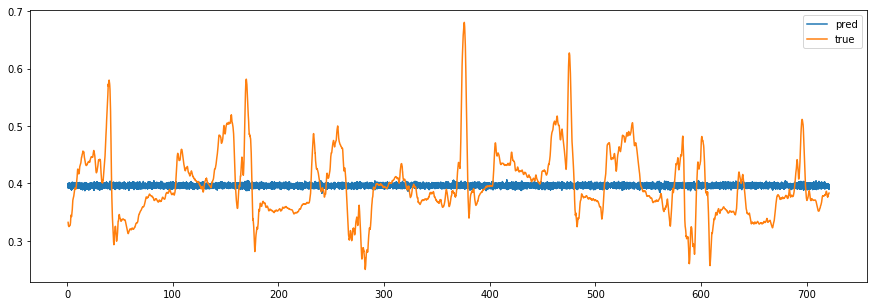

In [250]:
plt.figure(figsize= (15,5))
plt.plot(sig1.time[110:75110],Y_pred[:,i],label = "pred")
plt.plot(sig1.time[110:75110],Y_train[:,i],label = "true")
plt.legend()

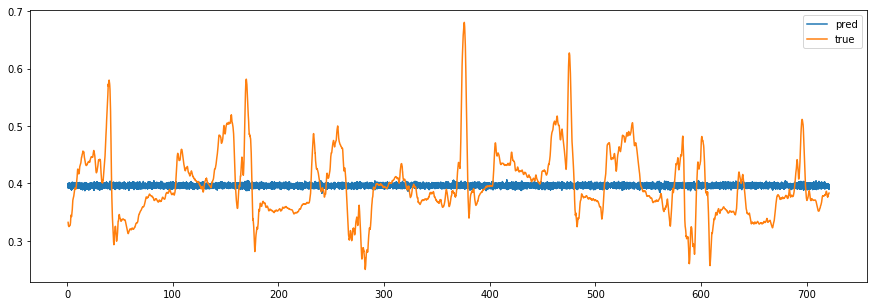

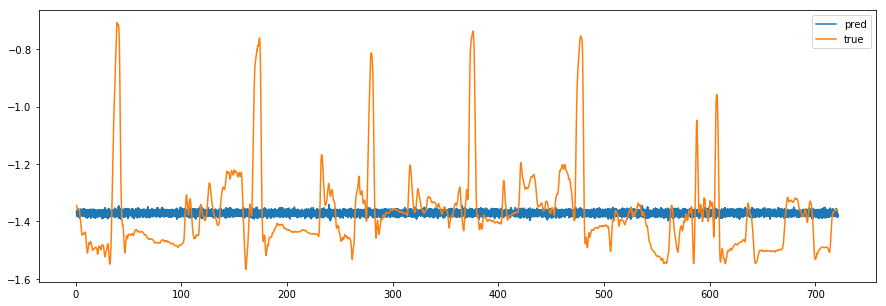

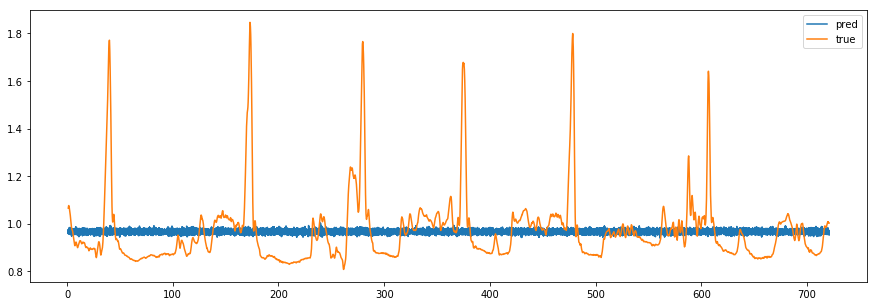

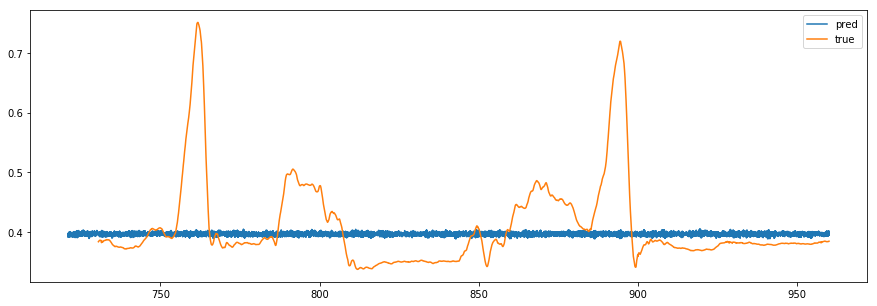

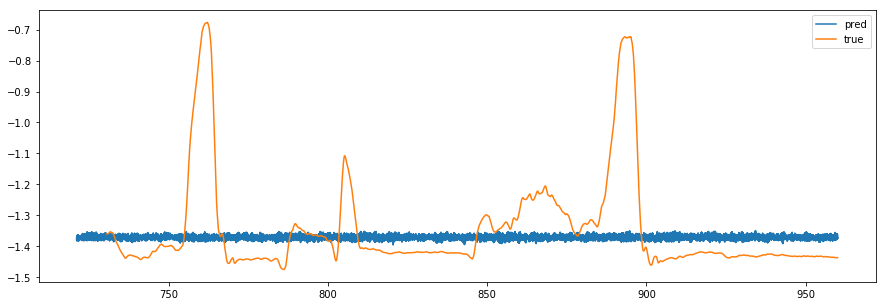

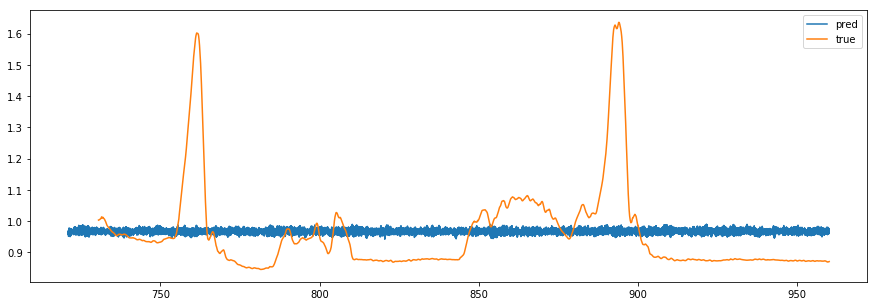

In [283]:

for i in range(3):
    plt.figure(figsize= (15,5))
    plt.plot(sig1.time[110:75110],Y_pred[:,i],label = "pred")
    plt.plot(sig1.time[110:75110],Y_train[:,i],label = "true")
    plt.legend()
X_test = X[75000:,:]
Y_test = Y[75000:,:]
Y_pred_test = model.predict(X_test)
for i in range(3):
    plt.figure(figsize= (15,5))
    plt.plot(sig1.time[75110:100000],Y_pred_test[:,i],label = "pred")
    plt.plot(sig1.time[76100:100000],Y_test[:,i],label = "true")
    plt.legend()

In [223]:
scipy.stats.pearsonr(Y_pred_test[:,0],Y_test[:,0])

(0.013923083747692888, 0.49628704637567256)